In [1]:
from pathlib import Path
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd

In [2]:
df_dir = 'dataset/'

In [3]:
def load_dataset(img_dir):
    p = Path(img_dir)
    dirs = p.glob('*')

    img_list = []

    for dir in dirs:
        label = dir.name
        for file in dir.glob('*.jpg'):
            img = mpimg.imread(file)

            if not img is None:
                img_list.append((img, label))
    
    return img_list

In [4]:
df = load_dataset(df_dir)

In [64]:
import matplotlib.pyplot as plt

def img_viz(img_list, num_img):
    if num_img < 0 or num_img >= len(img_list):
        raise IndexError("num_img out of range")
    
    img, label = img_list[num_img]

    img = np.array(img)

    cmap = "gray" if len(img.shape) == 2 else None

    plt.figure(figsize=(4,4))
    plt.imshow(img, cmap=cmap)
    plt.title(f"Label: {label}")
    plt.axis("off")
    plt.show()

    print(f"Shape\t: {img.shape}")
    print(f"Label\t: {label}")


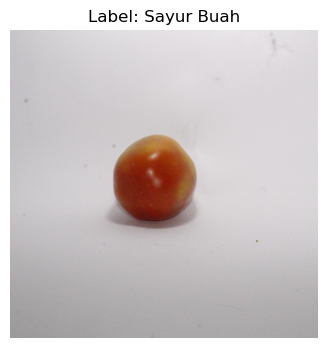

Shape	: (3456, 3456, 3)
Label	: Sayur Buah


In [65]:
img_viz(df, 40)

In [7]:
def crop_center(img, ratio=0.8):
    h, w = img.shape[:2]
    ch, cw = int(h * ratio), int(w * ratio)
    y1 = (h - ch) // 2
    x1 = (w - cw) // 2
    return img[y1:y1+ch, x1:x1+cw]

In [8]:
def apply_clahe(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=1.2, tileGridSize=(8,8))
    cl = clahe.apply(l)

    limg = cv2.merge((cl, a, b))
    return cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

In [41]:
def segment_object_otsu(img):
    gry = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    _, img_thresh = cv2.threshold(
        gry, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )

    kernel = np.ones((3,3), np.uint8)
    img_thresh_open = cv2.morphologyEx(img_thresh, cv2.MORPH_OPEN, kernel)

    img_thresh_inv = cv2.bitwise_not(img_thresh_open)
    img_thresh_final = cv2.erode(img_thresh_inv, kernel, iterations=1)

    mask3 = np.repeat((img_thresh_final // 255)[..., None], 3, axis=2).astype("uint8")

    masked_bgr = img * mask3
    
    masked_rgb = cv2.cvtColor(masked_bgr, cv2.COLOR_BGR2RGB)
    
    return masked_rgb


In [52]:
def preprocessing_basic(img_list):
    result = []
    for img, label in img_list:
        
        cropped = crop_center(img)
        resized = cv2.resize(cropped, (224, 224))
        clahe = apply_clahe(resized)
        #seg_mask = segment_object_otsu(clahe)   

        # final_img = clahe * (seg_mask > 0)

        result.append((clahe, label))
    
    return result


In [53]:
basic = preprocessing_basic(df)

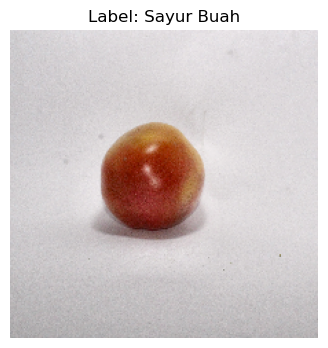

Shape	: (224, 224, 3)
Label	: Sayur Buah


In [ ]:
img_viz(basic, 0)

In [173]:
def augment_img_deterministic(img):
    out = []

    out.append(img.copy())

    out.append(cv2.flip(img, 1))

    out.append(cv2.flip(img, 0))

    out.append(cv2.convertScaleAbs(img, alpha=1.2, beta=10))

    out.append(cv2.convertScaleAbs(img, alpha=0.8, beta=-10))

    h, w = img.shape[:2]
    M1 = cv2.getRotationMatrix2D((w//2, h//2), 15, 1)
    out.append(cv2.warpAffine(img, M1, (w, h)))

    M2 = cv2.getRotationMatrix2D((w//2, h//2), -15, 1)
    out.append(cv2.warpAffine(img, M2, (w, h)))

    M3 = cv2.getAffineTransform(
        np.float32([[0, 0], [w, 0], [0, h]]),
        np.float32([[0, 0], [w*1.5, 0], [0, h*1.5]])
    )
    zoomed = cv2.warpAffine(img, M3, (w, h))
    out.append(zoomed)

    return out        

In [174]:
def apply_augmentation(processed_list):
    augmented = []
    for img, label in processed_list:
        augs = augment_img_deterministic(img)
        for aug_img in augs:
            augmented.append((aug_img, label))
    return augmented


In [175]:
aug = apply_augmentation(basic)

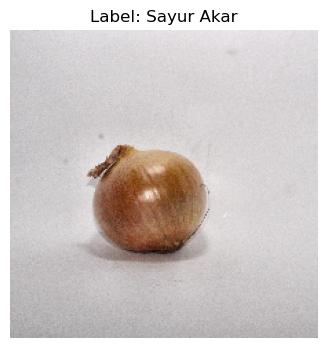

Shape	: (224, 224, 3)
Label	: Sayur Akar


In [176]:
img_viz(aug, 0)

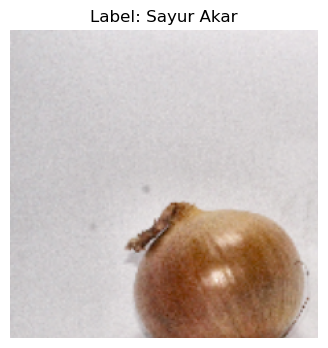

Shape	: (224, 224, 3)
Label	: Sayur Akar


In [177]:
img_viz(aug, 7)

In [144]:
def preprocess_for_HOG(processed_list):
    result = []
    for img, label in processed_list:
        grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(grey, (3,3), 0)
        result.append((blurred, label))
    return result

In [145]:
hog_img = preprocess_for_HOG(aug)

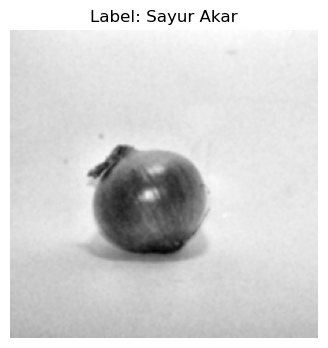

Shape	: (224, 224)
Label	: Sayur Akar


In [148]:
img_viz(hog_img, 0)

In [149]:
def preprocess_for_HSV(processed_list):
    result = []
    for img, label in processed_list:
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        result.append((hsv, label))
    return result

In [150]:
hsv_img = preprocess_for_HSV(aug)

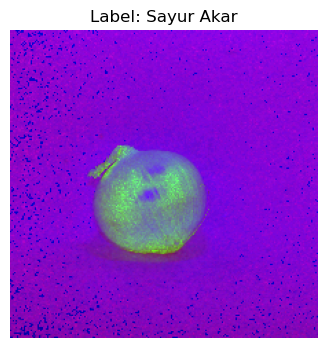

Shape	: (224, 224, 3)
Label	: Sayur Akar


In [151]:
img_viz(hsv_img, 0)

In [152]:
def preprocess_for_GLCM(processed_list):
    result = []
    for img, label in processed_list:
        grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        result.append((grey, label))
    return result

In [153]:
glcm_img = preprocess_for_GLCM(aug)

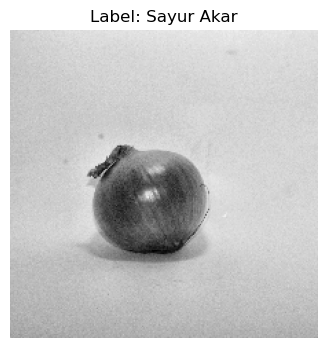

Shape	: (224, 224)
Label	: Sayur Akar


In [154]:
img_viz(glcm_img, 0)